In [24]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0
import os, sys
import time
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lib
import torch, torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

experiment_name = 'rating'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}'.format(experiment_name, *time.gmtime()[:5])
print("experiment:", experiment_name)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=0
experiment: rating_2024.03.02_07:55


In [25]:
data = lib.Dataset("ratings", data_path="/lustre/home/acct-stu/stu220/rllm-main/rllm/datasets/rel-movielens1m/regression",random_state=1337, quantile_transform=True, quantile_noise=1e-3)

in_features = data.X_train.shape[1]

mu, std = data.y_train.mean(), data.y_train.std()
normalize = lambda x: ((x - mu) / std).astype(np.float32)
data.y_train, data.y_valid, data.y_test = map(normalize, [data.y_train, data.y_valid, data.y_test])

print("mean = %.5f, std = %.5f" % (mu, std))

mean = 3.61688, std = 1.11024


In [26]:
model = nn.Sequential(
    lib.DenseBlock(in_features, 256, num_layers=2, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

with torch.no_grad():
    model = model.double().to(device)
    res = model(torch.as_tensor(data.X_train[:5000], device=device).double())
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

../lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)


In [27]:
from qhoptim.pyt import QHAdam
optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.9, 0.995),'lr': 0.001}

In [28]:
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)
# from torch.optim import Adam

# optimizer_params = {'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-8}

# trainer = lib.Trainer(
#     model=model,
#     loss_function=F.mse_loss,
#     experiment_name=experiment_name,
#     warm_start=False,
#     Optimizer=Adam,  # 使用Adam优化器
#     optimizer_params=optimizer_params,  # 设置优化器参数
#     verbose=True,
#     n_last_checkpoints=5
# )

In [29]:
from tqdm import tqdm
from IPython.display import clear_output
loss_history, mse_history = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 1000
report_frequency = 200

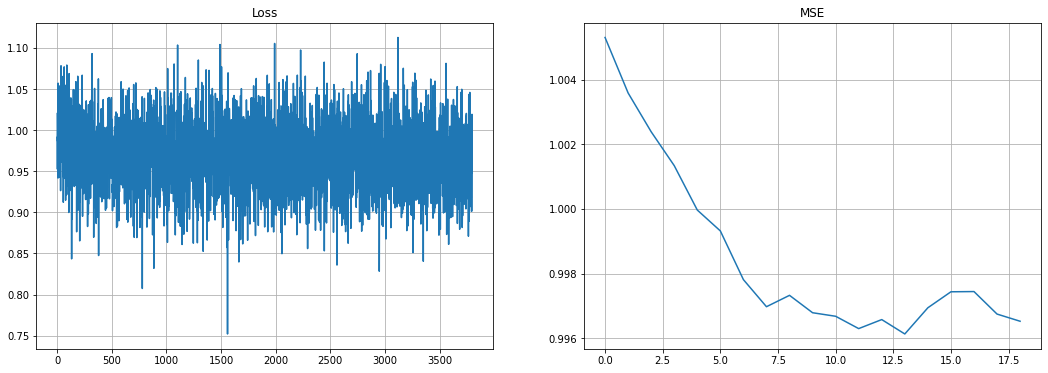

Loss 0.97685
Val MSE: 0.99652
BREAK. There is no improvment for 1000 steps
Best step:  2800
Best Val MSE: 0.99613


In [30]:
for batch in lib.iterate_minibatches(data.X_train, data.y_train, batch_size=1024, 
                                                shuffle=True, epochs=float('inf')):
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            data.X_valid, data.y_valid, device=device, batch_size=16384)

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history.append(mse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()

        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('Loss')
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(mse_history)
        plt.title('MSE')
        plt.grid()
        plt.show()
        print("Loss %.5f" % (metrics['loss']))
        print("Val MSE: %0.5f" % (mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

In [31]:
trainer.load_checkpoint(tag='best_mse')
mse = trainer.evaluate_mse(data.X_test, data.y_test, device=device)
mae = trainer.evaluate_mae(data.X_test, data.y_test, device=device)
print('Best step: ', trainer.step)
print("Test MSE: %0.5f" % (mse))
print("Test MAE: %0.5f" % (mae))


Loaded logs/rating_2024.03.02_07:55/checkpoint_best_mse.pth
Best step:  2800
Test MSE: 1.05904
Test MAE: 0.84268


In [32]:
mse * std ** 2

1.3054070242284104